# alphalens_Demo

## 导入模块

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import sunlandsdatasdk as sd
import feather
from datetime import datetime, timedelta
import sys

sys.path.append('../../public-Git/')
from alphalens_custom.tears import sd_get_Analysis_results
from alphalens_custom.utils import get_clean_factor_and_forward_returns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据准备, 行情 / 因子值

### 读入行情

In [2]:
prices = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')
prices = prices[prices['date'] >= '2018-01-01']
prices['close_adj'] = prices['close'] * prices['adj']
close = prices.pivot(index='date', columns='issue', values='close_adj')

In [3]:
close

issue,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,688787,688788,688789,688793,688798,688799,688800,688819,688981,689009
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1456.430446,4470.489815,90.786677,40.036045,327.212070,138.003576,193.399403,53.694565,59.044529,58.079758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,1417.096193,4438.910802,96.719916,39.572665,327.212070,138.003576,192.958356,54.428098,59.583256,58.283786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,1408.591490,4547.377846,94.444153,39.758017,327.212070,138.003576,191.414689,56.041869,59.044529,58.317790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,1413.906930,4772.549938,94.200321,40.221397,327.212070,138.003576,188.547879,55.381690,60.768456,61.038154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,1377.761940,4941.429006,92.818608,40.499425,327.212070,138.003576,186.783688,55.161630,66.802204,60.800122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,1523.190616,1370.046554,59.454301,NaN,307.187688,54.919791,71.706538,83.934475,29.414519,39.299937,...,161.440177,45.826940,149.253144,47.959324,102.985587,45.169450,74.826402,29.742836,97.99,45.327052
2024-12-26,1515.523549,1364.595441,63.111777,NaN,307.585085,56.327990,69.241625,83.306089,29.845501,39.344045,...,164.702879,46.284209,146.918999,48.484633,104.068462,45.586103,86.152554,30.496364,96.73,45.407615
2024-12-27,1511.690016,1371.863592,58.844722,NaN,318.712194,58.813049,69.465708,84.562862,30.168737,39.829229,...,160.875207,46.527133,147.183242,46.766730,103.716879,45.586103,79.751433,30.141130,97.51,47.169942


### 获取对标指数

In [4]:
# sd.auth('*', '*')
# benchmark = sd.get_index_bar('000905', start_date=20110101, end_date=20241231)
# benchmark['date'] = pd.to_datetime(benchmark['date'])
# benchmark = benchmark[['date', 'close']]
# feather.write_dataframe(benchmark, '../data/benchmark.feather')

In [5]:
benchmark = feather.read_dataframe('../data/benchmark.feather')
benchmark = benchmark.set_index('date')['close']

### 读入因子文件

In [6]:
factor = feather.read_dataframe('../data/N_connect_1_both/fill_neutral_N_connect_num.feather')
factor = factor.pivot(index='date', columns='issue', values='N_connect')
# factor = feather.read_dataframe('../data/ret_jump/fill_neutral_ret_jump.feather')
# factor = factor.pivot(index='date', columns='issue', values='neutral_factor')
factor = factor.reindex(index=close.index, columns=close.columns)

## 因子分析前置处理

### 上市日期限制标志

In [7]:
def filter_stock_byDate(close, filterdays_pre, filterdays_end):
    """
    按上市和退市时间标记可用时间为1，不可用为nan
    Parameters
    ----------
    close : 带有date和issue的时间序列.
    filterdays_pre : 上市filterdays_pre之后置标记
    filterdays_end : 退市filterdays_pre之前置标记

    Returns
    -------
    date,issue,filterFlag

    """
    close = close.astype('float64')
    close[close < 0.01] = np.nan
    filterFlag_pre = close.shift(filterdays_pre)
    filterFlag_pre.iloc[:filterdays_pre] = close.iloc[0]
    filterFlag_end = close.shift(-filterdays_end)
    filterFlag_end.iloc[-filterdays_end:] = close.iloc[-1]

    filterFlag = close*np.nan
    filterFlag[close.notna()] = 1
    filterFlag[filterFlag_pre.isna()] = np.nan
    filterFlag[filterFlag_end.isna()] = np.nan

    return filterFlag

In [8]:
filterFlag = filter_stock_byDate(close, 180, 0)
factor = factor * filterFlag

### 去除涨跌停股票

In [9]:
is_limit_buy = prices.pivot(index='date', columns='issue', values='is_limit_buy')
is_limit_sell = prices.pivot(index='date', columns='issue', values='is_limit_sell')
factor[is_limit_buy == 1] = np.nan
factor[is_limit_sell == 1] = np.nan

### 调整因子矩阵

In [10]:
factor = pd.DataFrame(factor.stack().rename('factor'))

In [11]:
factor

factor
date       issue         
2019-08-30 000001   571.0
           000002   693.0
           000004  1099.0
           000006   253.0
           000007  1052.0
...                   ...
2024-06-28 688799   452.0
           688800  2616.0
           688819   719.0
           688981   152.0
           689009  1843.0

[4710506 rows x 1 columns]

## 因子分析模块

### 对标指数超额收益模式

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 15.0%, not exceeded: OK!
FactorValues Quantiles Statistics


,min,max,mean,std,count,daily_count,count %
factor_quantile,,,,,,,
1,0.0,158.0,17.151127,21.671645,473656,405.0,10.05
2,19.0,584.0,179.509415,115.558804,469468,401.0,9.96
3,141.0,1056.0,563.139682,185.385341,470890,402.0,9.99
4,471.0,1398.0,991.950075,193.560231,471091,402.0,10.00
5,743.0,1747.0,1355.871161,199.764913,471271,403.0,10.00
6,1014.0,2065.0,1640.248676,212.397792,471083,402.0,10.00
7,1230.0,2322.0,1857.383500,226.269542,471197,403.0,10.00
8,1378.0,2533.0,2039.342247,238.280535,470885,402.0,9.99
9,1550.0,2715.0,2216.748658,251.597725,470637,402.0,9.99


Turnover Analysis


,1D,20D,60D
Quantile 1 Mean Turnover,0.030,0.008,0.005
Quantile 2 Mean Turnover,0.043,0.019,0.011
Quantile 3 Mean Turnover,0.053,0.027,0.013
Quantile 4 Mean Turnover,0.059,0.032,0.013
Quantile 5 Mean Turnover,0.063,0.034,0.014
Quantile 6 Mean Turnover,0.065,0.035,0.014
Quantile 7 Mean Turnover,0.065,0.035,0.014
Quantile 8 Mean Turnover,0.063,0.035,0.014
Quantile 9 Mean Turnover,0.057,0.032,0.013
Quantile 10 Mean Turnover,0.039,0.020,0.010


,1D,20D,60D
Mean Factor Rank Autocorrelation,0.996,0.923,0.769




benchmark AnalysisMode Returns Analysis 


,1D,20D,60D
Top Ret,5.69,6.25,5.21
Bottom Ret,6.50,9.92,9.41
Top RetAE,4.47,5.63,4.90
Bottom RetAE,5.55,9.66,9.27
Top RetAE MDD,-35.08,-18.22,-15.39
Top RetAE SPR,0.28,0.33,0.34




benchmark AnalysisMode Returns Analysis By Year 


,Top Ret,Top RetAE,Bottom Ret,Bottom RetAE,Spread Ret,Spread RetAE,RetAE Top SPR,RetAE Top MDD
date,,,,,,,,
2019,2.72,1.57,-9.61,-10.36,12.34,10.44,0.25,-4.20
2020,-1.50,-2.98,-12.70,-13.97,11.20,8.45,-0.29,-13.30
2021,6.86,5.61,10.55,9.51,-3.69,-5.98,0.41,-15.22
2022,10.78,9.60,21.95,21.00,-11.17,-13.31,0.70,-11.57
2023,22.24,21.28,18.36,17.82,3.88,2.38,2.11,-6.76
2024,-24.47,-25.80,-7.30,-8.31,-17.17,-19.52,-0.69,-34.93




Information Analysis


,1D,20D,60D
IC Mean,-0.018,-0.040,-0.060
IR,-0.111,-0.231,-0.420
Good IC Ratio,0.902,0.902,0.902
IC Mean SD_20D,-0.016,-0.048,-0.071
IR SD_20D,-0.021,-0.060,-0.102
IC Mean SD_60D,-0.072,-0.060,-0.095
IR SD_60D,-0.100,-0.084,-0.139


<Figure size 640x480 with 0 Axes>

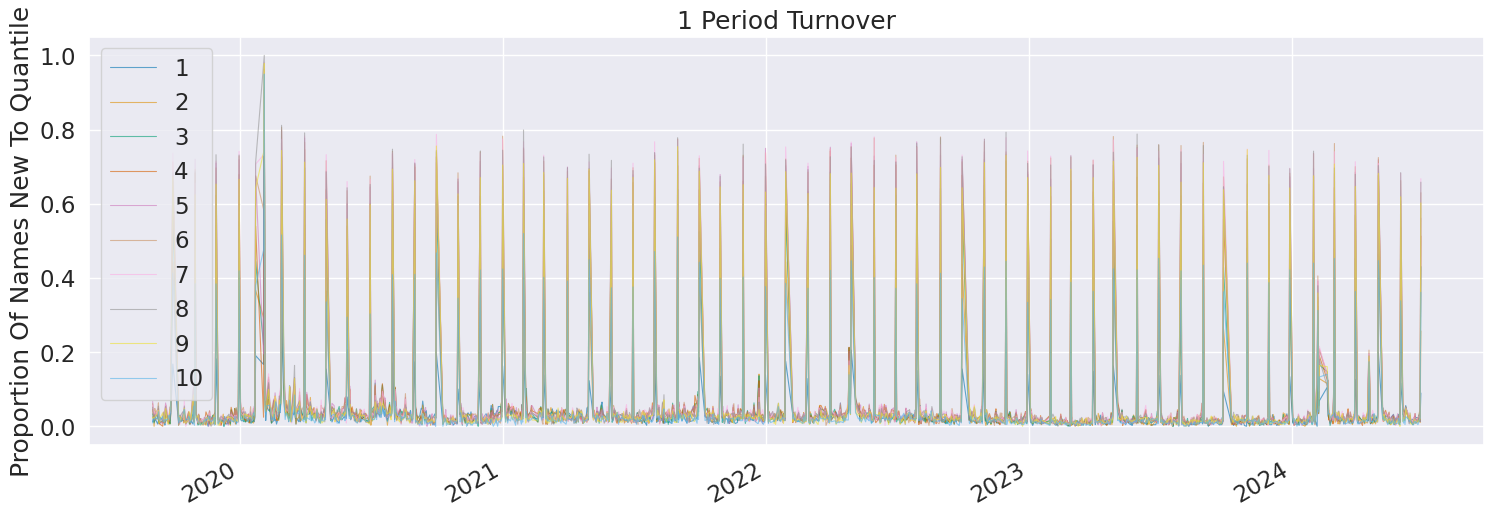

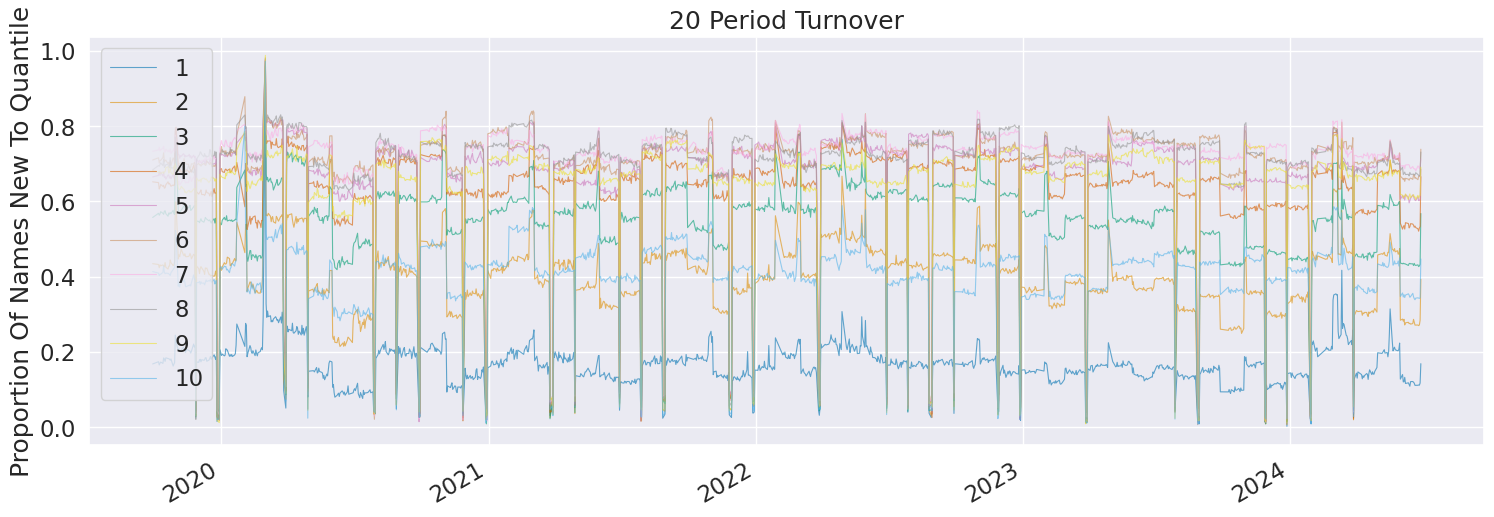

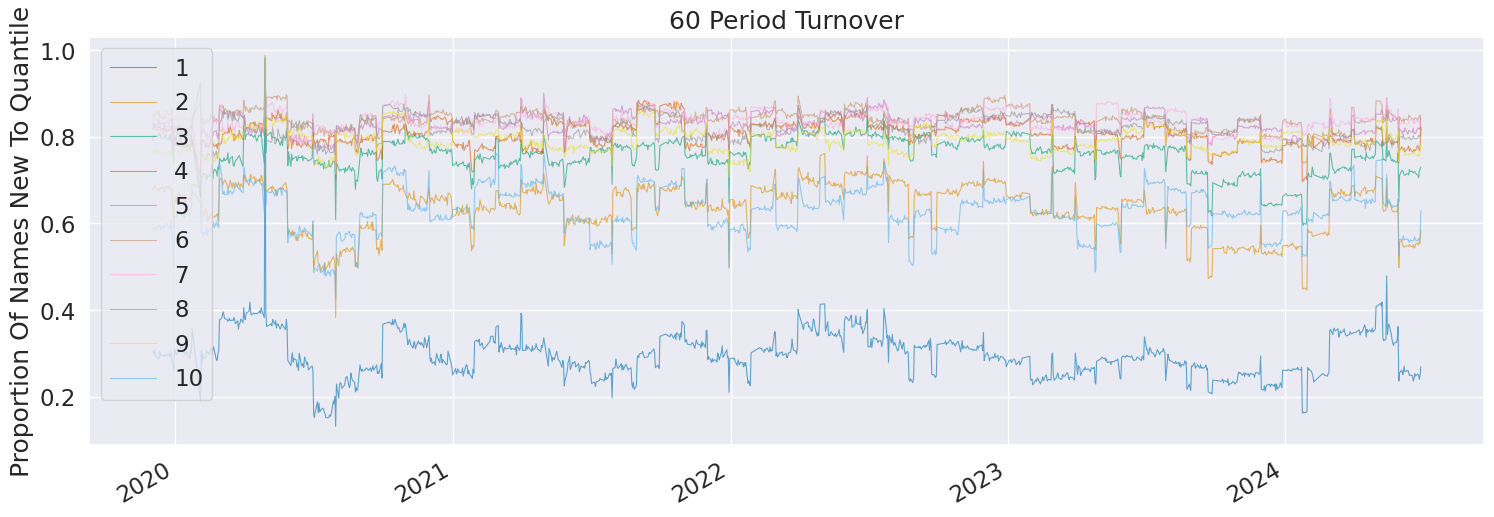

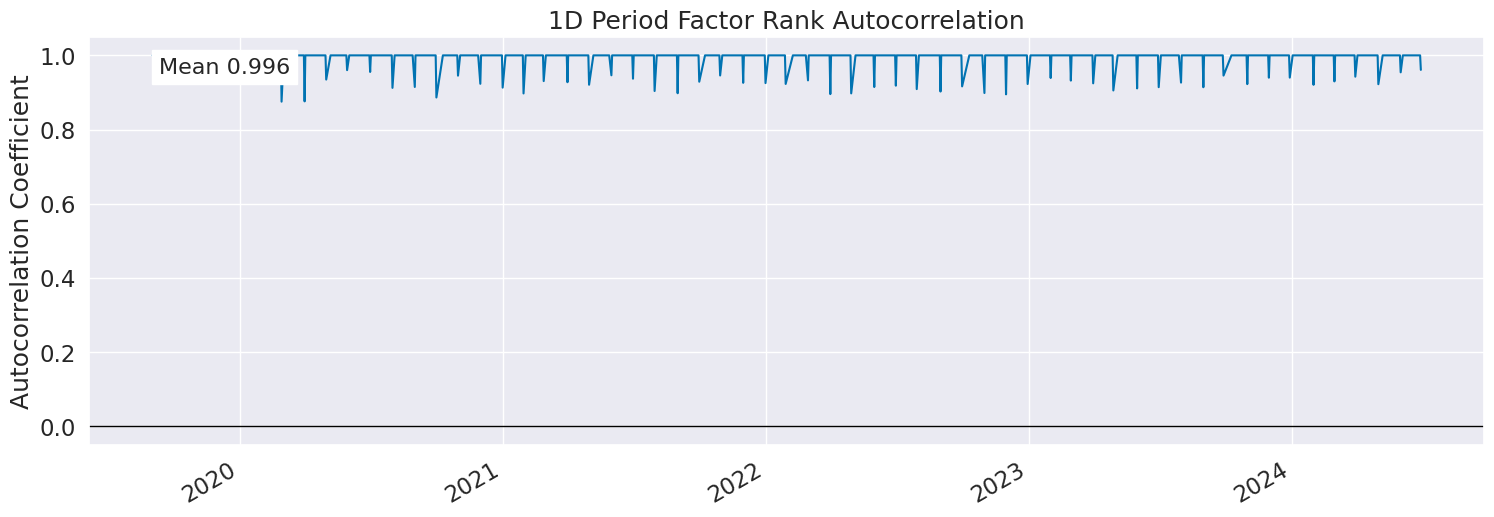

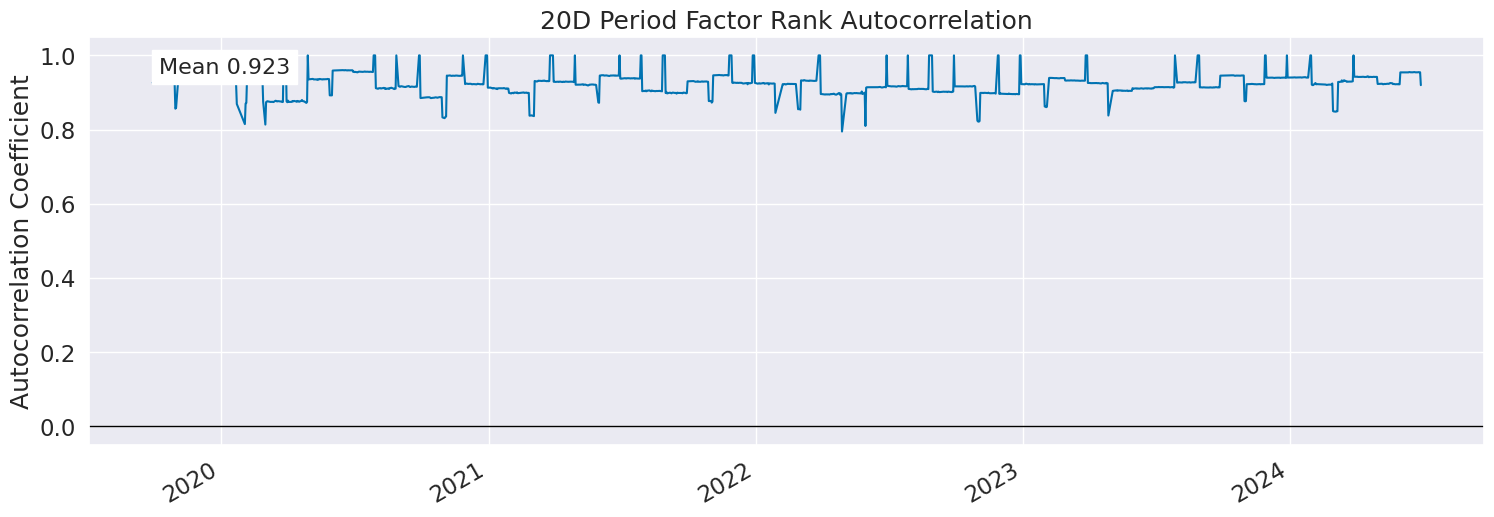

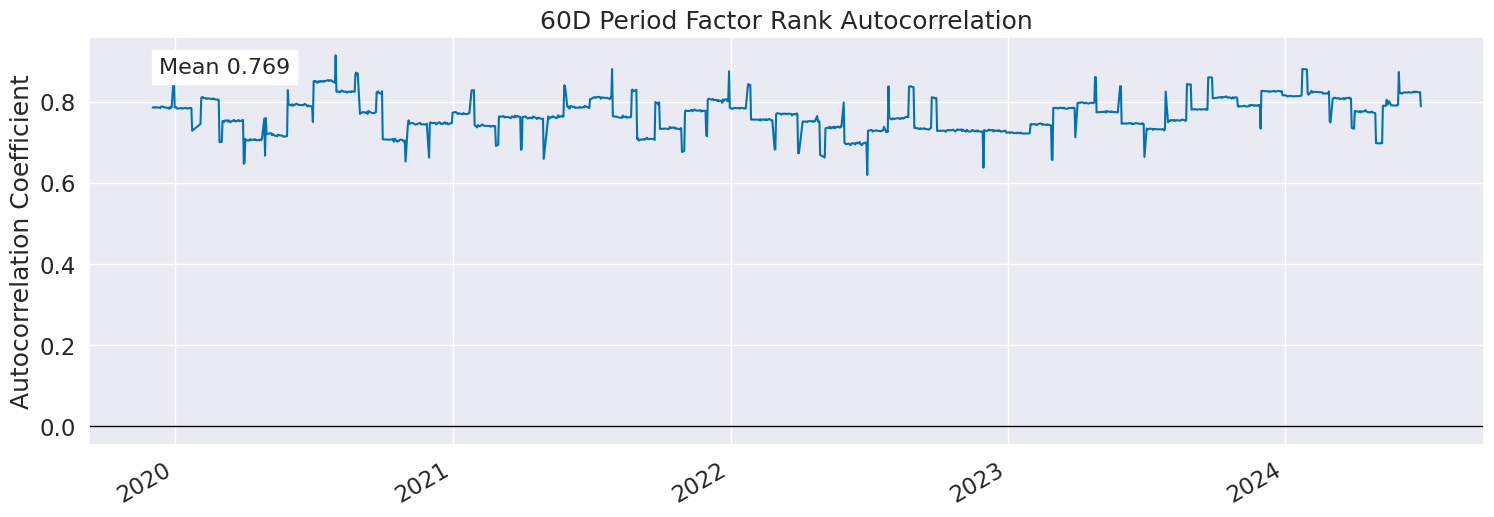

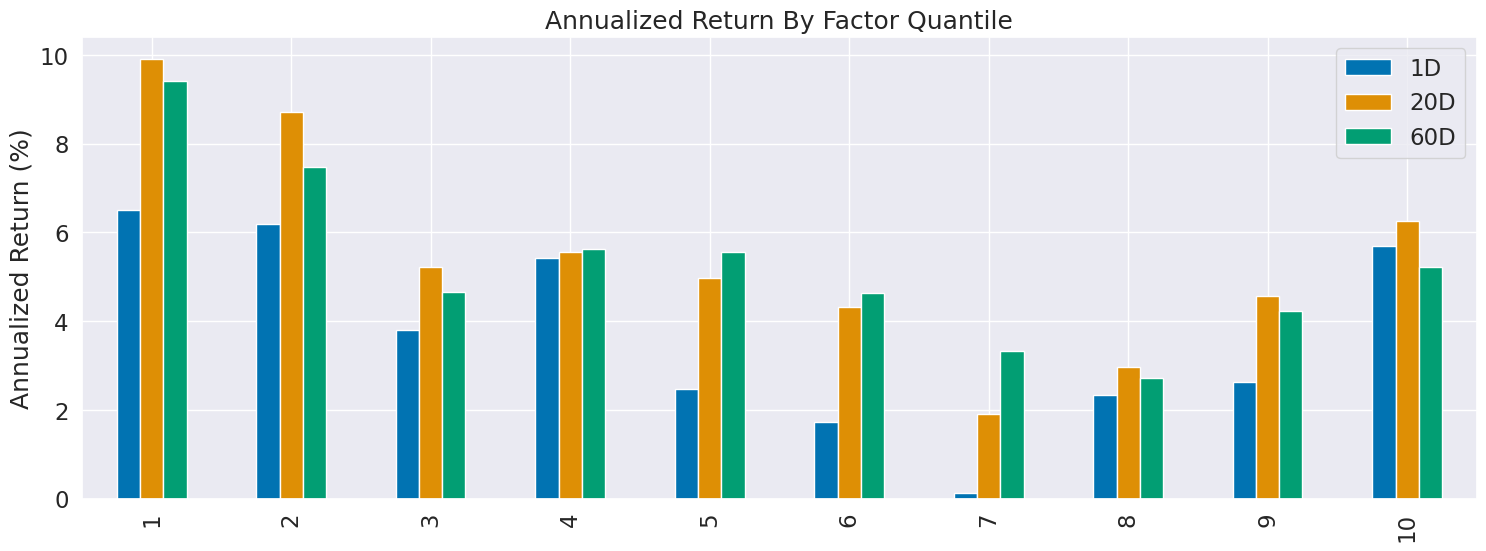

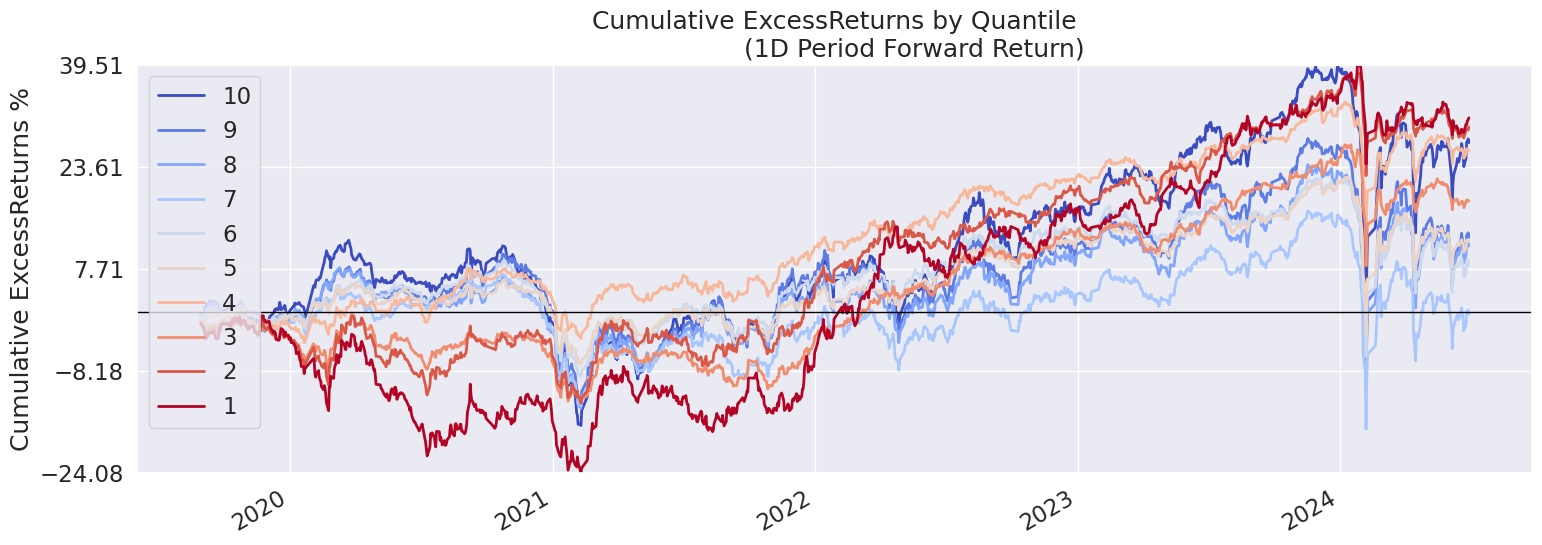

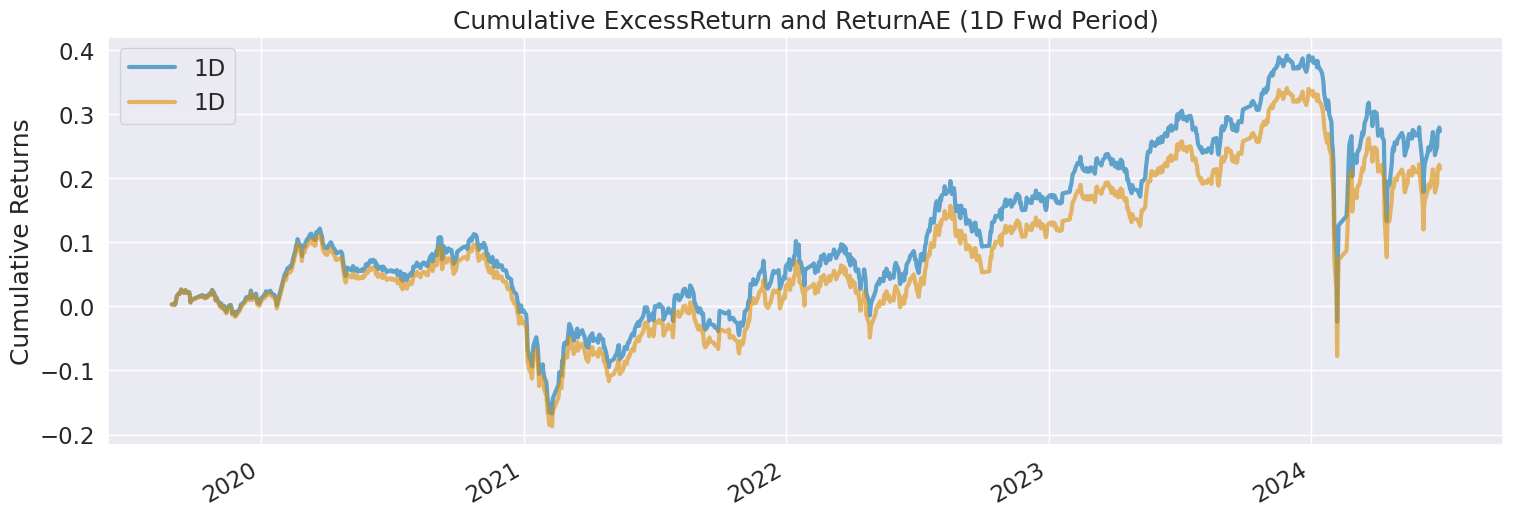

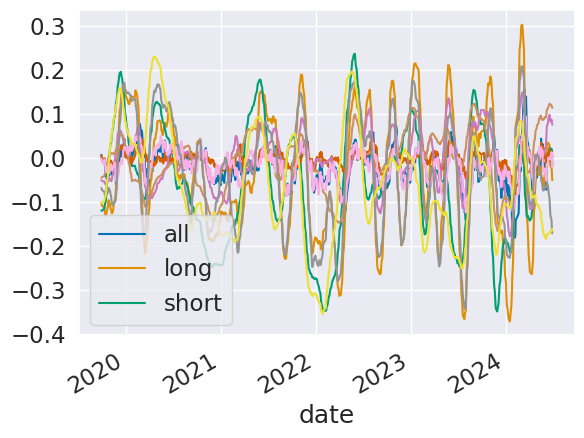

In [12]:
factor_data = get_clean_factor_and_forward_returns(
    factor=factor, prices=close,
    quantiles=10,
    benchmark=benchmark,
    bins=None,
    periods=(1, 20, 60),
    filter_zscore=20000,
    max_loss=0.15,
    zero_aware=False,
    cumulative_returns=True
)
results = sd_get_Analysis_results(factor_data, ana_mode='benchmark', plot=True)